Device: cuda.


100%|██████████| 50/50 [24:15<00:00, 29.10s/it, C_loss=-2.06, G_loss=0.219]


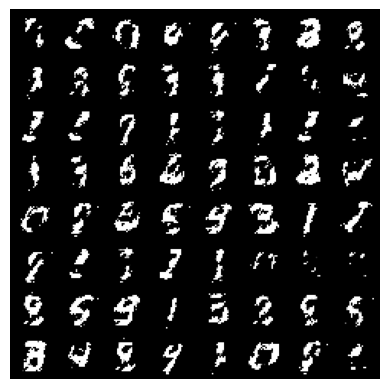

In [3]:
import torch
import tqdm
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}.')

# Datos:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)  # Cambiado a 64 según el paper

# Redes neuronales:
class Generator(nn.Module):
    def __init__(self, output_shape, hidden_dim=100):
        super().__init__()
        self.output_shape = output_shape
        self.hidden_dim = hidden_dim
        channels, height, width = output_shape

        self.layer = nn.Sequential(
            nn.Linear(hidden_dim, 128), nn.ReLU(),  # Cambiado a ReLU
            nn.Linear(128, 256), nn.ReLU(),  # Eliminado BatchNorm, cambiado a ReLU
            nn.Linear(256, 512), nn.ReLU(),  # Eliminado BatchNorm, cambiado a ReLU
            nn.Linear(512, 1024), nn.ReLU(),  # Eliminado BatchNorm, cambiado a ReLU
            nn.Linear(1024, channels * height * width), nn.Tanh()
        )

    def forward(self, x):
        batch_size = len(x)
        x = self.layer(x)
        return x.view(batch_size, *self.output_shape)

class Critic(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        channels, height, width = input_shape
        self.layer = nn.Sequential(
            nn.Linear(channels * height * width, 512), nn.ReLU(),  # Cambiado a ReLU
            nn.Linear(512, 256), nn.ReLU(),  # Cambiado a ReLU
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = nn.Flatten()(x)
        return self.layer(x)

# Entrenamiento:
def train_wgan(generator, critic, dataloader, epochs, lr=5e-5, clip_value=0.01, n_critic=5):
    generator.to(device)
    critic.to(device)

    # Optimizadores:
    generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=lr)
    critic_optimizer = torch.optim.RMSprop(critic.parameters(), lr=lr)

    try:
        progressbar = tqdm.trange(epochs)
        for epoch in progressbar:
            epoch_critic_loss = 0
            epoch_generator_loss = 0

            for i, (x_true, _) in enumerate(dataloader):
                batch_size = x_true.size(0)

                # ---------- Entrenamiento critic ----------
                for _ in range(n_critic):
                    # Datos reales:
                    x_true = x_true.to(device)
                    x_true_pred = critic(x_true)

                    # Datos sintéticos:
                    z = torch.randn(batch_size, generator.hidden_dim, device=device)
                    x_fake = generator(z)
                    x_fake_pred = critic(x_fake)

                    # Pérdida del critic (Wasserstein loss)
                    critic_loss = -torch.mean(x_true_pred) + torch.mean(x_fake_pred)

                    epoch_critic_loss += critic_loss.item()
                    critic_optimizer.zero_grad()
                    critic_loss.backward()
                    critic_optimizer.step()

                    # Clip weights of critic
                    for p in critic.parameters():
                        p.data.clamp_(-clip_value, clip_value)

                # ---------- Entrenamiento generador ----------
                # Datos sintéticos:
                z = torch.randn(batch_size, generator.hidden_dim, device=device)
                x_fake = generator(z)
                x_fake_pred = critic(x_fake)

                # Pérdida del generador (Wasserstein loss)
                generator_loss = -torch.mean(x_fake_pred)

                epoch_generator_loss += generator_loss.item()
                generator_optimizer.zero_grad()
                generator_loss.backward()
                generator_optimizer.step()

            epoch_critic_loss /= len(dataloader)
            epoch_generator_loss /= len(dataloader)
            progressbar.set_postfix(C_loss=epoch_critic_loss, G_loss=epoch_generator_loss)

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

# Tamaño de entrada y salida:
image_shape = dataset[0][0].shape

# Redes generadora y critic:
generator = Generator(image_shape)
critic = Critic(image_shape)

# Entrenamiento:
train_wgan(generator, critic, dataloader, epochs=50)

# Generación de muestras:
def generate_images(generator, filename, n_samples=64):
    generator.eval()
    z = torch.randn(n_samples, generator.hidden_dim).to(device)

    with torch.no_grad():
        samples = generator(z).cpu()
        samples = make_grid(samples).permute(1,2,0)

    plt.imshow(samples.clip(0,1), cmap='gray')
    plt.axis('off')
    #plt.savefig(f'images/dm/{filename}.pdf', bbox_inches='tight')
    plt.show()

generate_images(generator, filename='wgan_mnist')